In [2]:
"""
Simplified submission script for the CORDEX ML-Benchmark. 

This script generates predictions for all available test files and formats 
them according to the required directory structure.
"""

import os
import sys
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import zipfile
import glob

# Set paths
DATA_PATH = '/r/scratch/users/mschillinger/data/cordexbench'
OUTPUT_BASE = '/r/scratch/groups/downscaling/submission_cordexbench'
TEMPLATES_PATH = '/r/scratch/users/mschillinger/data/ml-benchmark/format_predictions/templates'

# Set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MMap the different domains to training GCMs and spatial dimensions
DOMAIN_INFO = {
               'NZ': {'train_gcm': 'ACCESS-CM2', 'spatial_dims': ('lat', 'lon')},
               'SA': {'train_gcm': 'ACCESS-CM2', 'spatial_dims': ('lat', 'lon')},
               'ALPS': {'train_gcm': 'CNRM-CM5', 'spatial_dims': ('x', 'y')},}

# Set the experiments to run
EXPERIMENTS = ['ESD_pseudo_reality', 'Emulator_hist_future']

# Computes the predictions for a specific predictor file
def format_prediction(domain, experiment, predictor_path, period_folder, condition, gcm_inference, orog=False, 
                      folder_samples={"tasmax": "maybritt_normpw_v2", "pr": "maybritt_scalepw_v2"}):
    
    ds_test = xr.open_dataset(predictor_path)
    if domain == 'SA': ds_test = ds_test.drop_vars('time_bnds', errors='ignore')
    
    # Predict for both pr and tasmax
    ds_out = xr.Dataset(coords={'time': ds_test.time})
    spatial_dims = DOMAIN_INFO[domain]['spatial_dims']

    # Iterate over the variables to predict
    for var in ['pr', 'tasmax']:
        # Load template for coordinates and variable attributes
        template_path = os.path.join(TEMPLATES_PATH, f'{var}_{domain}.nc')
        ds_template = xr.open_dataset(template_path)
        n_gridpoints = ds_template[spatial_dims[0]].size * ds_template[spatial_dims[1]].size

        # Now load preds from pt on disk
        # e.g. /r/scratch/groups/downscaling/samples_cordexbench/Emulator_hist_future/NZ/no-orog/tasmax/maybritt_normpw_v2
        # samples_end_century_perfect_ACCESS-CM2.pt
        
        # Construct the path to the prediction file
        orog_str = "with-orog" if orog else "no-orog"
        pred_file = f"samples_{period_folder}_{condition}_{gcm_inference}.pt"
        pred_path = os.path.join('/r/scratch/groups/downscaling/samples_cordexbench', experiment, domain, orog_str, var, folder_samples[var], pred_file)
        
        print("loading predictions from:", pred_path)
        # Load predictions from disk
        preds = torch.load(pred_path, map_location=DEVICE).cpu().numpy().squeeze(1)
        print(preds.shape)
        # FLIP BACK 
        preds = np.flip(preds, axis=1)
        num_members = 5

        # Unstack back to 2D grid using template dimensions
        # It is necessary to set the order due to differences in lat/lon and x/y spatial dimensions
        if domain == 'NZ' or domain == 'SA':
            order = 'C'
        elif domain == 'ALPS':
            order = 'F'
            
        preds_reshaped = preds.reshape(len(ds_test.time), ds_template[spatial_dims[0]].size, ds_template[spatial_dims[1]].size, num_members,
                                       order=order)
        
        # Create DataArray with template's spatial coords and attributes
        da = xr.DataArray(preds_reshaped,
                          coords={**ds_template.coords, 'time': ds_test.time, 'member': np.arange(num_members)},
                          dims=('time',) + spatial_dims + ('member',),
                          name=var,
                          attrs=ds_template[var].attrs)
        ds_out[var] = da

    return ds_out

In [4]:
# Create the output base directory
os.makedirs(OUTPUT_BASE, exist_ok=True)

# Iterate over the domains
for domain in DOMAIN_INFO:
    print(f"Processing Domain: {domain}")
    
    # Find all test predictor files for this domain
    test_dir = f'{DATA_PATH}/{domain}/{domain}_domain/test'
    predictor_files = glob.glob(f'{test_dir}/**/*.nc', recursive=True)
    
    # lr_path = f'{DATA_PATH}/test/{test_params["period"]}/predictors/{test_params["framework"]}/{test_params["gcm"]}_{period_inference}.nc'
    for pred_path in predictor_files[:1]:
        # Parse path parts: .../test/{period}/predictors/{condition}/{filename}.nc
        parts = pred_path.split(os.sep)
        # Find the index of 'test' to extract the period folder
        test_idx = parts.index('test')
        # Extract the period folder
        period_folder = parts[test_idx + 1]
        # Extract the condition
        condition = parts[test_idx + 3]
        # Extract the filename
        filename = parts[-1]            
        gcm_inference = filename.split('_')[0]  # e.g. ACCESS-CM2_historical.nc -> ACCESS-CM2
        
        # Iterate over the experiments
        for experiment in EXPERIMENTS:
            print(f"Predicting {filename} for {experiment}...")
            
            ds_preds = format_prediction(domain, experiment, pred_path, period_folder, condition, gcm_inference,
                                         folder_samples={"tasmax": "maybritt_normpw_v2", "pr": "maybritt_scalepw_v2"})
            
            # Build output path: Domain_Domain/Experiment/period/condition/
            out_dir = os.path.join(OUTPUT_BASE, f"{domain}_Domain", experiment, period_folder, condition)
            os.makedirs(out_dir, exist_ok=True)
            
            out_filename = f"Predictions_pr_tasmax_{filename}"
            ds_preds.to_netcdf(os.path.join(out_dir, out_filename))

# ZIP the submission using the "emulator_id" code specified in the registration
zip_filename = "enscale.zip"  # replace the "emulator_id" text
zip_path = os.path.join(OUTPUT_BASE, zip_filename)

print(f"Creating submission package: {zip_path}")
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(OUTPUT_BASE):
        for file in files:
            abs_path = os.path.join(root, file)
            rel_path = os.path.relpath(abs_path, OUTPUT_BASE)
            zipf.write(abs_path, rel_path)

print("Done!")

Processing Domain: NZ
Predicting ACCESS-CM2_1981-2000.nc for ESD_pseudo_reality...
loading predictions from: /r/scratch/groups/downscaling/samples_cordexbench/ESD_pseudo_reality/NZ/no-orog/pr/maybritt_scalepw_v2/samples_historical_perfect_ACCESS-CM2.pt
(7300, 128, 128, 5)
loading predictions from: /r/scratch/groups/downscaling/samples_cordexbench/ESD_pseudo_reality/NZ/no-orog/tasmax/maybritt_normpw_v2/samples_historical_perfect_ACCESS-CM2.pt
(7300, 128, 128, 5)
Predicting ACCESS-CM2_1981-2000.nc for Emulator_hist_future...
loading predictions from: /r/scratch/groups/downscaling/samples_cordexbench/Emulator_hist_future/NZ/no-orog/pr/maybritt_scalepw_v2/samples_historical_perfect_ACCESS-CM2.pt
(7300, 128, 128, 5)
loading predictions from: /r/scratch/groups/downscaling/samples_cordexbench/Emulator_hist_future/NZ/no-orog/tasmax/maybritt_normpw_v2/samples_historical_perfect_ACCESS-CM2.pt
(7300, 128, 128, 5)
Processing Domain: SA
Predicting ACCESS-CM2_1981-2000.nc for ESD_pseudo_reality...
l

KeyboardInterrupt: 

In [29]:
ds1 = xr.open_dataset("/r/scratch/groups/downscaling/submission_cordexbench/NZ_Domain/Emulator_hist_future/historical/perfect/Predictions_pr_tasmax_ACCESS-CM2_1981-2000.nc")
ds1.close()

In [31]:
import gc

ds1.close()
del ds1
gc.collect()

5085

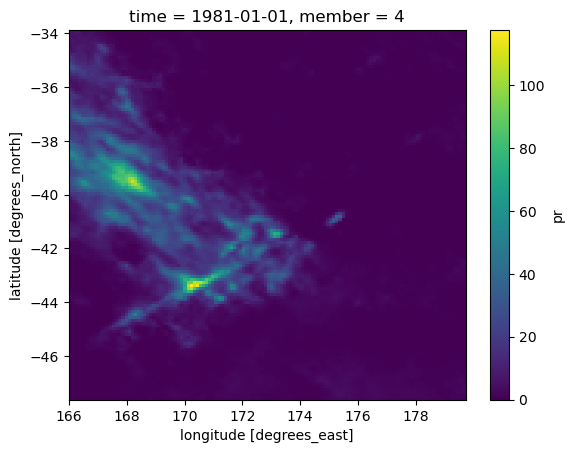

In [25]:
ds1.pr[0, ..., 4].plot()